#### 인셉션 모듈

In [1]:
# 인셉션 모듈을 만드는 데에 필요한 모듈 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model # 모델 시각화

In [2]:
# Naïve Inception 블록을 만들기 위한 함수
def naive_inception(input_layer, conv1_filter, conv3_filter, conv5_filter):
    # 1x1 사이즈의 kernel을 이용한 convolution2d layer
    conv1 = keras.layers.Conv2D(conv1_filter, (1,1), padding='same', activation='relu')(input_layer)

    conv3 = keras.layers.Conv2D(conv1_filter, (3,3), padding='same', activation='relu')(input_layer)
    
    conv5 = keras.layers.Conv2D(conv1_filter, (5,5), padding='same', activation='relu')(input_layer)
    
    # 3x3 max pooling layer (데이터의 가로 세로를 3x3로 살펴보고 가장 큰 값만 뽑아낸다)
    pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    # 위에서 언급한 4개의 layer 통해서 나온 feature map들을 모두 concatenation 한다.
    out_layer = keras.layers.Concatenate()([conv1, conv3, conv5, pool])
    return out_layer

In [3]:
input_data = keras.layers.Input(shape=(256, 256, 3))
naive_inception_out = naive_inception(input_data, 64, 128, 32)

In [4]:
print(naive_inception_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 195), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [5]:
# 모델 만들기
model = keras.models.Model(inputs=input_data, outputs=naive_inception_out)
# 생성한 모델의 구조 확인하기
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         256       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 64)         4864      ['input_1[0][0]']             
                                                                                              

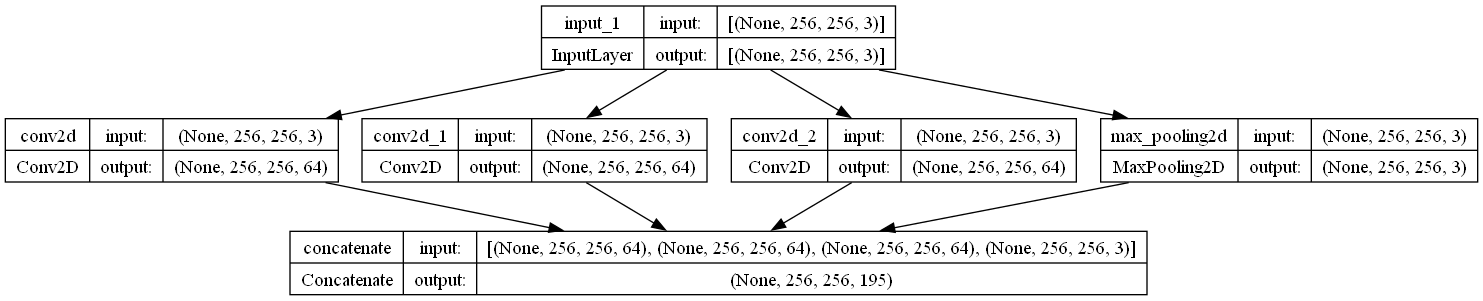

In [6]:
# 모델 구조 시각화하기
plot_model(model, show_shapes=True)

### Inception module with 1x1 convolution

In [9]:
# Inception 블록을 만들기 위한 함수
def inception(input_layer, conv1_filter, conv3_in, conv3_out, conv5_in, conv5_out, pooling_out):
    # 1x1 사이즈의 kernel을 이용한 convolution2d layer
    conv1 = keras.layers.Conv2D(conv1_filter, (1,1), padding='same', activation='relu')(input_layer)
    # 3x3 사이즈의 kernel을 이용한 convolution2d layer
    conv3 = keras.layers.Conv2D(conv3_in, (1,1), padding='same', activation='relu')(input_layer) # Naive 버전과 가장 차별화되는 부분: 1x1 convolution
    conv3 = keras.layers.Conv2D(conv3_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 사이즈의 kernel을 이용한 convolution2d layer
    conv5 = keras.layers.Conv2D(conv5_in, (1,1), padding='same', activation='relu')(input_layer)
    conv5 = keras.layers.Conv2D(conv5_out, (5,5), padding='same', activation='relu')(conv5)
    
    
    # 3x3 max pooling layer (데이터의 가로 세로를 3x3로 살펴보고 가장 큰 값만 뽑아낸다)
    pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    pool = keras.layers.Conv2D(pooling_out, (1,1), padding='same', activation='relu')(pool)
    # 위에서 언급한 4개의 layer 통해서 나온 feature map들을 모두 concatenation 한다.
    out_layer = keras.layers.Concatenate()([conv1, conv3, conv5, pool])
    return out_layer

In [10]:
input_data = keras.layers.Input(shape=(256, 256, 3))
inception_out = inception(input_data, 64, 96, 128, 16, 32, 32)

In [11]:
# 모델 만들기
model = keras.models.Model(inputs=input_data, outputs=inception_out)
# 생성한 모델의 구조 확인하기
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 256, 256, 96)         384       ['input_2[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 256, 16)         64        ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 256, 256, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                       

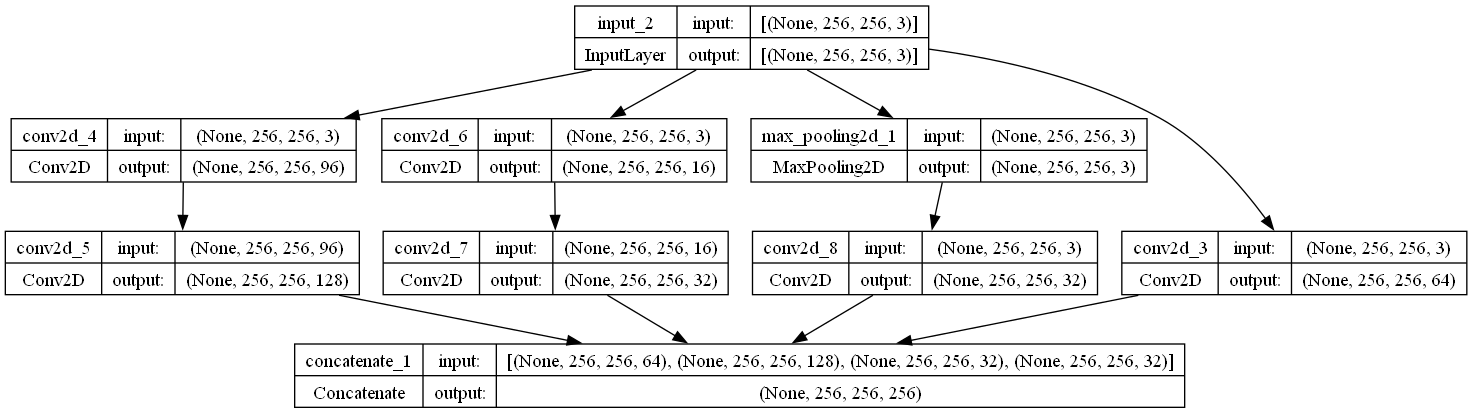

In [12]:
plot_model(model, show_shapes=True)

#### Skip Connection

In [14]:
# skip connection이 구현된 함수 residual_module을 정의
# residual_module을 정의할 때 주의점은 skip connection을 구성하기 위해서 connection을 통해서 합해지는 feature map들의 가로x세로x채널 사이즈가 맞아야 한다는 것
def residual_module(input_layer, n_filters):  
	merge_input = input_layer

# if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
	if input_layer.shape[-1] != n_filters:
		merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.
	# Conv2D layer
	conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
	# Conv2D layer
	conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
	
  # Add를 통해서 skip connection을 구현하는 부분
	out_layer = keras.layers.Add()([conv2, merge_input])
	out_layer = keras.layers.Activation('relu')(out_layer)
 
	return out_layer

In [15]:
input = keras.layers.Input(shape=(256, 256, 3))
residual_out = residual_module(input, 64)

In [16]:
print(residual_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 64), dtype=tf.float32, name=None), name='activation/Relu:0', description="created by layer 'activation'")


In [17]:
model = keras.models.Model(inputs=input, outputs=residual_out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_10[0][0]']           
                                                                                                  
 conv2d_9 (Conv2D)           (None, 256, 256, 64)         256       ['input_3[0][0]']             
                                                                                            

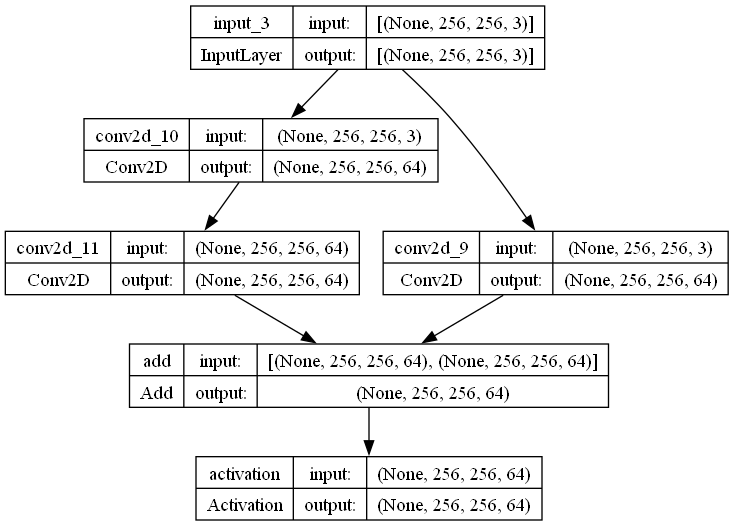

In [18]:
plot_model(model, show_shapes=True)